In [1]:
!pip install opendatasets
!pip install pandas

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, classification_report, confusion_matrix
import transformers
from transformers import AutoModel, BertTokenizerFast, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from torch.optim import AdamW

device = torch.device("cpu")

In [3]:
import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/abdullah0a/social-media-sentiment-analysis-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: julfiqureantor
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/abdullah0a/social-media-sentiment-analysis-dataset


100%|██████████| 384k/384k [00:00<00:00, 526MB/s]

In [4]:
file_path = '/content/social-media-sentiment-analysis-dataset/synthetic_social_media_data.csv'
df = pd.read_csv(file_path, encoding='latin-1')
df.head()

,Post ID,Post Content,Sentiment Label,Number of Likes,Number of Shares,Number of Comments,User Follower Count,Post Date and Time,Post Type,Language
0,aa391375-7355-44b7-bcbf-97fb4e5a2ba3,Word who nor center everything better politica...,Neutral,157,243,64,4921,2024-01-10 00:14:21,video,fr
1,1c9ec98d-437a-48d9-9cba-bd5ad853c59a,Begin administration population good president...,Positive,166,49,121,612,2024-02-03 00:20:11,image,es
2,170e5b5b-1d9a-4d02-a957-93c4dbb18908,Thousand total sign. Agree product relationshi...,Positive,185,224,179,9441,2024-07-25 14:20:23,video,de
3,aec53496-60ee-4a06-8821-093a04dc8770,Individual from news third. Oil forget them di...,Neutral,851,369,39,6251,2024-02-20 09:15:09,text,de
4,4eacddb7-990d-4056-8784-7e1d5c4d1404,Time adult letter see reduce. Attention sudden...,Negative,709,356,52,1285,2024-03-01 04:17:35,image,de


In [5]:
# Define groups manually
# Based on the output of df['Sentiment'].unique(), it appears the sentiment labels are in the header row
# and the actual sentiment values are not in the 'Sentiment' column as expected.
# Let's inspect the dataframe head again to understand the column structure.

# It seems the header was incorrectly parsed. The actual sentiment label is in the first column.
# Let's redefine the column names and then map the sentiment.

# Redefine column names based on the actual header row
new_column_names = ['Post ID', 'Post Content', 'Sentiment Label', 'Number of Likes', 'Number of Shares', 'Number of Comments', 'User Follower Count', 'Post Date and Time', 'Post Type', 'Language']
df.columns = new_column_names

# Now, let's check the unique values in the 'Sentiment Label' column
print(df['Sentiment Label'].unique())

# Assuming 'Positive', 'Negative', and 'Neutral' are the sentiment labels
positive = ['Positive']
negative = ['Negative']
neutral = ['Neutral'] # Add neutral

# Create a function to map
def map_sentiment(s):
    if s in positive:
        return 1  # positive
    elif s in negative:
        return 0  # negative
    elif s in neutral:
        return 2 # neutral
    else:
        return -1  # unknown/unmapped

# Apply the mapping to the correct column
df['label'] = df['Sentiment Label'].apply(map_sentiment)

# Drop unknown labels (if any)
df = df[df['label'] != -1]

print(df['label'].value_counts())

['Neutral' 'Positive' 'Negative']
label
2    682
0    675
1    643
Name: count, dtype: int64


In [6]:
# check class distribution
df['label'].value_counts(normalize=True)

,proportion
label,
2,0.3410
0,0.3375
1,0.3215


In [7]:
train_text, temp_text, train_labels, temp_labels = train_test_split(
    df['Post Content'], df['label'],
    random_state=2018,
    test_size=0.3,
    stratify=df['label']
)

val_text, test_text, val_labels, test_labels = train_test_split(
    temp_text, temp_labels,
    random_state=2018,
    test_size=0.5,
    stratify=temp_labels
)

In [8]:
# Import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [9]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    padding=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    padding=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    padding=True,
    truncation=True
)

In [10]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [11]:
batch_size = 16

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [12]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
model = model.to(device)

optimizer = AdamW(model.parameters(),lr = 1e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels.values
)
print("Class Weights:",class_weights)

Class Weights: [0.98661029 1.03703704 0.97833683]


In [14]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.CrossEntropyLoss(weight=weights)

# number of training epochs
epochs = 5

In [15]:
def train():
    model.train()
    total_loss = 0
    total_preds = []
    total_labels = []

    for batch in train_dataloader:
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch

        model.zero_grad()

        outputs = model(sent_id, attention_mask=mask)
        logits = outputs.logits  # <-- Fix here

        loss = cross_entropy(logits, labels)  # <-- Define loss correctly
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
        total_preds.extend(preds)
        total_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(train_dataloader)
    accuracy = accuracy_score(total_labels, total_preds)

    return avg_loss, accuracy


In [16]:
def evaluate():
    model.eval()
    total_preds = []
    total_labels = []

    with torch.no_grad():
        for batch in val_dataloader:
            batch = [t.to(device) for t in batch]
            sent_id, mask, labels = batch

            outputs = model(sent_id, attention_mask=mask)
            logits = outputs.logits  # <-- Fix here

            preds = torch.argmax(logits, dim=1)

            total_preds.extend(preds.cpu().numpy())
            total_labels.extend(labels.cpu().numpy())

    val_accuracy = accuracy_score(total_labels, total_preds)
    return val_accuracy


In [17]:
# Re-initialize the model with the correct number of labels
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
model = model.to(device)

# Re-define the optimizer as the model parameters have changed
optimizer = AdamW(model.parameters(), lr = 1e-5)

# Restart the training loop
best_val_accuracy = 0.0  # To track the best validation accuracy

training_loss_list = []
validation_accuracy_list = []

for epoch in range(epochs):
    print(f'\nEpoch {epoch + 1}/{epochs}')

    # Train and get loss
    train_loss, _ = train()

    # Evaluate and get accuracy
    val_acc = evaluate()

    # Store metrics
    training_loss_list.append(train_loss)
    validation_accuracy_list.append(val_acc)

    print(f'Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}')

    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        torch.save(model.state_dict(), 'best_bert_model.pt')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5
Train Loss: 1.1143 | Val Acc: 0.3200

Epoch 2/5
Train Loss: 1.1030 | Val Acc: 0.3133

Epoch 3/5
Train Loss: 1.0905 | Val Acc: 0.3300

Epoch 4/5
Train Loss: 1.0246 | Val Acc: 0.3267

Epoch 5/5
Train Loss: 0.8940 | Val Acc: 0.3400


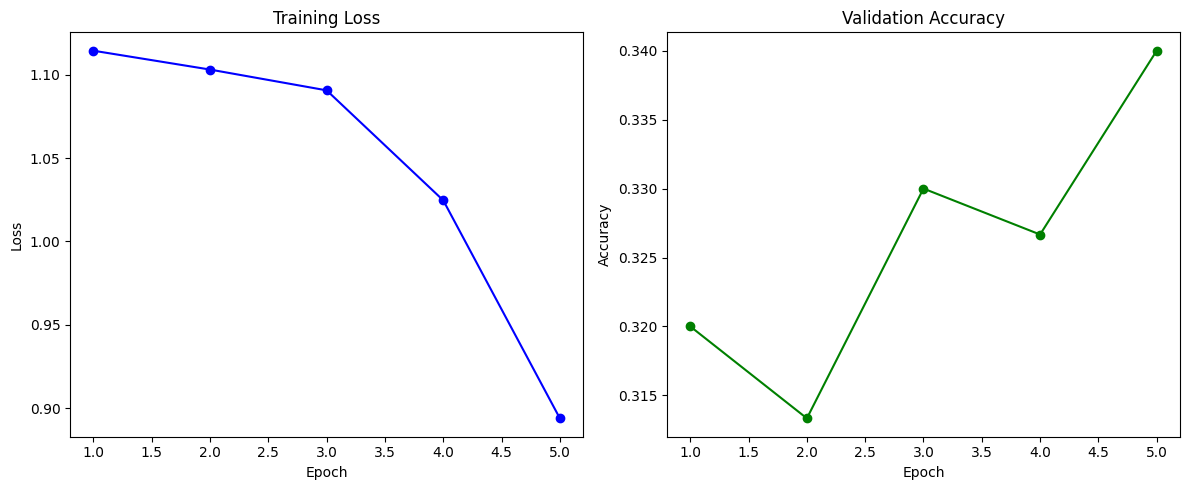

In [18]:
epochs_range = range(1, len(training_loss_list) + 1)

plt.figure(figsize=(12, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_loss_list, 'b-o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, validation_accuracy_list, 'g-o')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()


Best Validation Accuracy: 0.3400

Classification Report:

              precision    recall  f1-score   support

    Negative     0.3833    0.4554    0.4163       101
    Positive     0.2000    0.1146    0.1457        96
     Neutral     0.3600    0.4369    0.3947       103

    accuracy                         0.3400       300
   macro avg     0.3144    0.3356    0.3189       300
weighted avg     0.3167    0.3400    0.3223       300



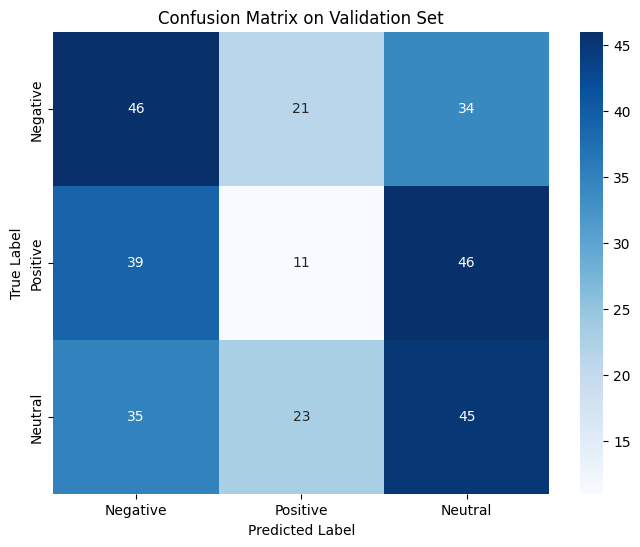

In [19]:
# Load best model
model.load_state_dict(torch.load('best_bert_model.pt'))
model.eval()

# Gather predictions & true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_dataloader:
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch

        outputs = model(sent_id, attention_mask=mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report and confusion matrix
print(f"\nBest Validation Accuracy: {best_val_accuracy:.4f}\n")
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=['Negative', 'Positive', 'Neutral'], digits=4))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive', 'Neutral'], yticklabels=['Negative', 'Positive', 'Neutral'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Validation Set')
plt.show()